In [ ]:
%load_ext autoreload
%autoreload 2

## Imports

In [ ]:
import pathlib
import random
import time

import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn, optim
from torch.nn.functional import interpolate
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision.transforms.functional import adjust_brightness

from super_resolution.src.sen2venus_dataset import (
    create_train_test_split,
)
from super_resolution.src.visualization import plot_gallery
from super_resolution.src.srgan import SRResNet, Discriminator

In [ ]:
DATA_DIR = pathlib.Path("C:/Users/Mitch/stat3007_data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

## Prepare Data

In [ ]:
sites = {
    "SO2",
    # "FR-BIL",
    # "NARYN",
}
train_patches, test_patches = create_train_test_split(
    str(SITES_DIR) + "\\", sites=sites
)
print(f"Num train {len(train_patches)}\n" f"Num test {len(test_patches)}")

In [ ]:
def image_transform(x, y):
    x = x[:3, :, :]
    y = y[:3, :, :]

    x = torch.clamp(x, 0, 1)
    y = torch.clamp(y, 0, 1)

    return x, y

In [ ]:
train_patches.set_transform(image_transform)
test_patches.set_transform(image_transform)

In [ ]:
train_loader = DataLoader(train_patches, batch_size=100)

In [ ]:
(low_res, high_res) = next(train_loader.__iter__())

In [ ]:
index = random.randint(0, len(low_res) - 1)
low_res_example = low_res[index]


high_res_example = high_res[index]


plot_gallery(
    [
        adjust_brightness(low_res_example, 2).permute(1, 2, 0),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res"],
    xscale=5,
    yscale=5,
)

## Training

In [ ]:
# For clearing GPU memory
# 1 / 0

In [ ]:
# For clearing GPU memory
import gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
BATCH_SIZE = 16
GEN_LEARNING_RATE = 1e-5
DISCRIM_LEARNING_RATE = 1e-5
GEN_WEIGHT_DECAY = 1e-8
DISCRIM_WEIGHT_DECAY = 1e-8
DISCRIM_WEIGHT = 1e-4

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
should_pin_memory = {"cuda": True, "cpu": False}

train_loader = DataLoader(
    train_patches,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    pin_memory=should_pin_memory[device.type],
    num_workers=0,
)

In [ ]:
device

In [ ]:
generator = SRResNet(scaling_factor=2, n_blocks=8)

In [ ]:
discriminator = Discriminator(n_blocks=8, fc_size=512)

In [227]:
generator = generator.to(device)
generator = generator.train()

In [ ]:
discriminator = discriminator.to(device)
discriminator = discriminator.train()

In [ ]:
gen_optimizer = optim.Adam(
    generator.parameters(), lr=GEN_LEARNING_RATE, weight_decay=GEN_WEIGHT_DECAY
)

discrim_optimizer = optim.Adam(
    discriminator.parameters(),
    lr=DISCRIM_LEARNING_RATE,
    weight_decay=DISCRIM_WEIGHT_DECAY,
)

In [ ]:
# save_file = RESULTS_DIR / "srganreal_gen_only.pkl"
# loaded_experiment = torch.load(save_file, map_location=device)
# # generator = SRResNet(scaling_factor=2, n_blocks=16).to(device)
# # discriminator = Discriminator(n_blocks=3, fc_size=128)
# generator.load_state_dict(loaded_experiment["gen_state"])
# discriminator.load_state_dict(loaded_experiment["discrim_state"])
# gen_optimizer.load_state_dict(loaded_experiment["gen_optimizer_state"])
# discrim_optimizer.load_state_dict(loaded_experiment["discrim_optimizer_state"])
# gen_losses = loaded_experiment["gen_losses"]
# discrim_losses = loaded_experiment["discrim_losses"]

In [ ]:
pixel_criterion = nn.MSELoss()
discrim_criterion = nn.BCEWithLogitsLoss()

In [ ]:
NUM_EPOCHS = 2000

In [ ]:
train_time = 0.0
gen_losses = []
discrim_losses = []

In [228]:
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm.tqdm(train_loader, total=len(train_loader), ncols=100)
    gen_epoch_loss = 0.0
    discrim_epoch_loss = 0.0
    num_batches = 0
    for i, (low_res_batch, high_res_batch) in enumerate(progress_bar):
        num_batches += 1
        start_time = time.time()

        # Push to GPU
        low_res_batch = low_res_batch.to(device)
        high_res_batch = high_res_batch.to(device)

        # Update generator
        ############################################################################################
        super_resolved = generator(low_res_batch)  # .clamp(0, 1)
        natural_probs = discriminator(super_resolved)

        pixel_loss = pixel_criterion(super_resolved, high_res_batch)
        adversarial_loss = discrim_criterion(
            natural_probs, torch.ones_like(natural_probs)
        )
        gen_loss = pixel_loss

        # if gen_epoch_loss / num_batches < 0.0005:
        gen_loss += 1e-4 * adversarial_loss

        if i % 5 == 0:
            gen_optimizer.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

        # Update discriminator
        ############################################################################################
        true_natural_probs = discriminator(high_res_batch)

        # Detach to skip generator computations
        fake_natural_probs = discriminator(super_resolved.detach())

        true_natural_loss = discrim_criterion(
            true_natural_probs, torch.ones_like(true_natural_probs)
        )
        fake_natural_loss = discrim_criterion(
            fake_natural_probs, torch.zeros_like(fake_natural_probs)
        )
        discrim_loss = true_natural_loss + fake_natural_loss

        # if gen_loss.item() < 0.0005:
        discrim_optimizer.zero_grad()
        discrim_loss.backward()
        discrim_optimizer.step()

        # Collect data
        gen_epoch_loss += gen_loss.item()
        discrim_epoch_loss += discrim_loss.item()
        progress_bar.set_postfix(
            epoch=epoch,
            gen_loss=f"{gen_epoch_loss/num_batches:.8f}",
            discrim_loss=f"{discrim_epoch_loss/num_batches:.8f}",
        )

        end_time = time.time()
        train_time += end_time - start_time

    gen_epoch_loss /= len(train_loader)
    discrim_epoch_loss /= len(train_loader)
    gen_losses.append(gen_epoch_loss)
    discrim_losses.append(discrim_epoch_loss)
    print(
        f"Epoch: {epoch} / gen_loss: {gen_epoch_loss:.8f} / discrim_loss: {discrim_epoch_loss:.8f}"
    )

100%|████████| 32/32 [00:22<00:00,  1.40it/s, discrim_loss=0.00675765, epoch=0, gen_loss=0.00131337]


Epoch: 0 / gen_loss: 0.00131337 / discrim_loss: 0.00675765


100%|████████| 32/32 [00:22<00:00,  1.42it/s, discrim_loss=0.00151842, epoch=1, gen_loss=0.00119356]


Epoch: 1 / gen_loss: 0.00119356 / discrim_loss: 0.00151842


100%|████████| 32/32 [00:22<00:00,  1.42it/s, discrim_loss=0.00639036, epoch=2, gen_loss=0.00107579]


Epoch: 2 / gen_loss: 0.00107579 / discrim_loss: 0.00639036


100%|████████| 32/32 [00:22<00:00,  1.42it/s, discrim_loss=0.01122797, epoch=3, gen_loss=0.00107903]


Epoch: 3 / gen_loss: 0.00107903 / discrim_loss: 0.01122797


100%|████████| 32/32 [00:22<00:00,  1.42it/s, discrim_loss=0.00984257, epoch=4, gen_loss=0.00105584]


Epoch: 4 / gen_loss: 0.00105584 / discrim_loss: 0.00984257


100%|████████| 32/32 [00:22<00:00,  1.41it/s, discrim_loss=0.47927199, epoch=5, gen_loss=0.00123494]


Epoch: 5 / gen_loss: 0.00123494 / discrim_loss: 0.47927199


100%|████████| 32/32 [00:22<00:00,  1.40it/s, discrim_loss=0.13370383, epoch=6, gen_loss=0.00132535]


Epoch: 6 / gen_loss: 0.00132535 / discrim_loss: 0.13370383


100%|████████| 32/32 [00:22<00:00,  1.40it/s, discrim_loss=0.02826771, epoch=7, gen_loss=0.00149333]


Epoch: 7 / gen_loss: 0.00149333 / discrim_loss: 0.02826771


100%|████████| 32/32 [00:22<00:00,  1.41it/s, discrim_loss=0.01531865, epoch=8, gen_loss=0.00150955]


Epoch: 8 / gen_loss: 0.00150955 / discrim_loss: 0.01531865


100%|████████| 32/32 [00:22<00:00,  1.42it/s, discrim_loss=0.01562143, epoch=9, gen_loss=0.00145688]


Epoch: 9 / gen_loss: 0.00145688 / discrim_loss: 0.01562143


100%|███████| 32/32 [00:22<00:00,  1.40it/s, discrim_loss=0.01197941, epoch=10, gen_loss=0.00138724]


Epoch: 10 / gen_loss: 0.00138724 / discrim_loss: 0.01197941


100%|███████| 32/32 [00:22<00:00,  1.40it/s, discrim_loss=0.01522810, epoch=11, gen_loss=0.00115473]


Epoch: 11 / gen_loss: 0.00115473 / discrim_loss: 0.01522810


100%|███████| 32/32 [00:22<00:00,  1.40it/s, discrim_loss=0.00896940, epoch=12, gen_loss=0.00121840]


Epoch: 12 / gen_loss: 0.00121840 / discrim_loss: 0.00896940


100%|███████| 32/32 [00:22<00:00,  1.41it/s, discrim_loss=0.02380848, epoch=13, gen_loss=0.00109327]


Epoch: 13 / gen_loss: 0.00109327 / discrim_loss: 0.02380848


100%|███████| 32/32 [00:22<00:00,  1.40it/s, discrim_loss=0.01941225, epoch=14, gen_loss=0.00133550]


Epoch: 14 / gen_loss: 0.00133550 / discrim_loss: 0.01941225


100%|███████| 32/32 [00:22<00:00,  1.41it/s, discrim_loss=0.00558542, epoch=15, gen_loss=0.00101419]


Epoch: 15 / gen_loss: 0.00101419 / discrim_loss: 0.00558542


100%|███████| 32/32 [00:22<00:00,  1.40it/s, discrim_loss=0.01780992, epoch=16, gen_loss=0.00095355]


Epoch: 16 / gen_loss: 0.00095355 / discrim_loss: 0.01780992


 56%|███▉   | 18/32 [00:12<00:10,  1.40it/s, discrim_loss=0.11727911, epoch=17, gen_loss=0.00113307]

In [ ]:
train_time / 60

In [ ]:
len(gen_losses)

In [ ]:
gen_losses[-5:]

In [ ]:
plt.plot(gen_losses)
plt.title("Generator losses")
plt.xlabel("Epoch")
plt.ylabel("Perceptual Loss")
plt.show()

In [ ]:
plt.plot(discrim_losses)
plt.title("Discriminator losses")
plt.xlabel("Epoch")
plt.ylabel("Crossentropy Loss")
plt.show()

## Saving

In [ ]:
experiment = {
    "gen_losses": gen_losses,
    "discrim_losses": discrim_losses,
    "gen_state": generator.state_dict(),
    "discrim_state": discriminator.state_dict(),
    "gen_optimizer_state": gen_optimizer.state_dict(),
    "discrim_optimizer_state": discrim_optimizer.state_dict(),
    "gen_learning_rate": GEN_LEARNING_RATE,
    "discrim_learning_rate": DISCRIM_LEARNING_RATE,
    "gen_weight_decay": GEN_WEIGHT_DECAY,
    "discrim_weight_decay": DISCRIM_WEIGHT_DECAY,
    "train_time": train_time,
}

In [ ]:
save_file = RESULTS_DIR / "srganreal_discrimnow_gettindecent.pkl"

In [ ]:
if not save_file.exists():
    torch.save(experiment, save_file)
    print(f"Saved to {save_file}")

## Generated Examples

In [206]:
generator = generator.to("cpu")

In [ ]:
loader = DataLoader(train_patches, batch_size=100)
(low_res, high_res) = next(loader.__iter__())

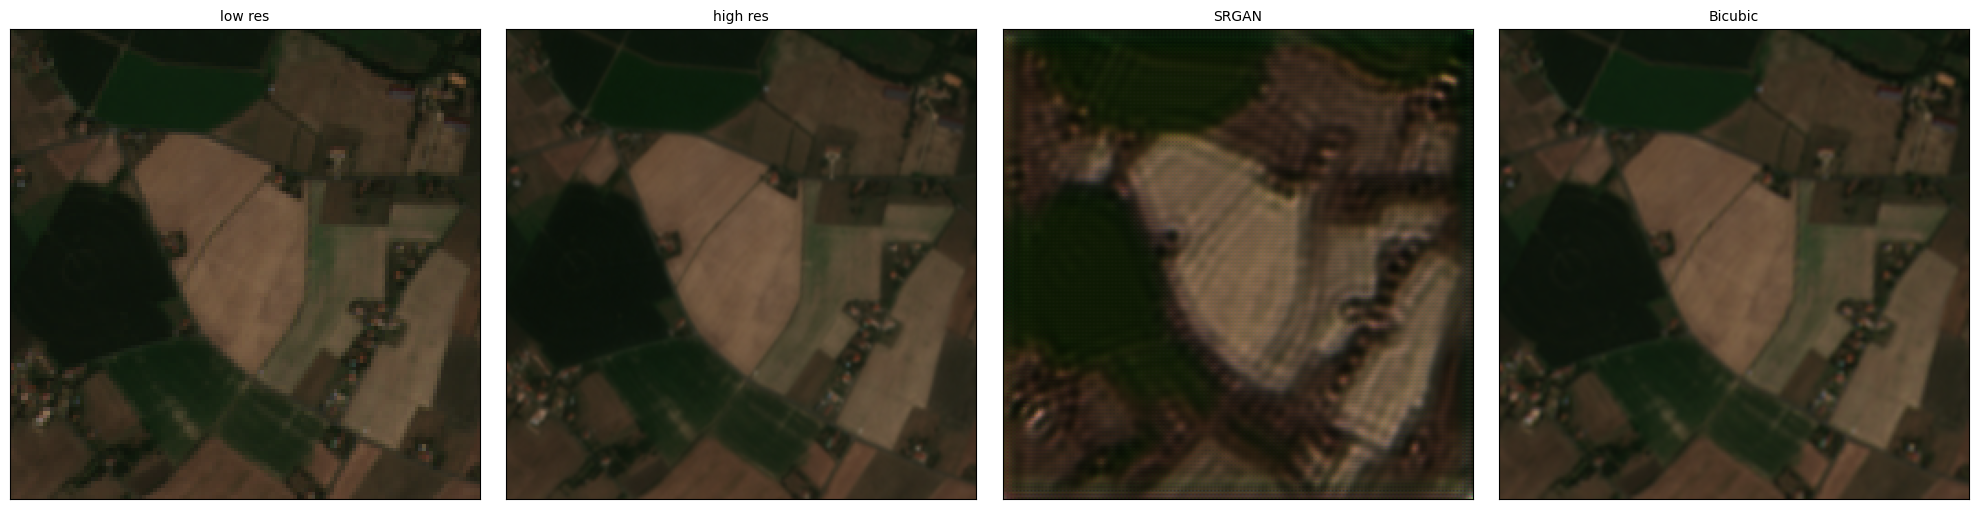

In [226]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]
out = generator(low_res_example.unsqueeze(0)).detach().clamp(0, 1)
bicubic_out = interpolate(
    low_res_example.unsqueeze(0),
    size=(256, 256),
    mode="bicubic",
).float()
plot_gallery(
    [
        adjust_brightness(low_res_example, 2).permute(1, 2, 0),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
        adjust_brightness(out[0], 2).permute(1, 2, 0),
        adjust_brightness(bicubic_out[0], 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res", "SRGAN", "Bicubic"],
    xscale=5,
    yscale=5,
)

In [ ]:
loader = DataLoader(test_patches, batch_size=300)
(low_res, high_res) = next(loader.__iter__())

In [ ]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]

out = generator(low_res_example.unsqueeze(0)).detach().clamp(0, 1)[0]
out = adjust_brightness(out, 2)

bicubic_out = (
    interpolate(low_res_example.unsqueeze(0), size=(256, 256), mode="bicubic")
    .float()
    .clamp(0, 1)
)[0]
bicubic_out = adjust_brightness(bicubic_out, 2)

low_res_example = adjust_brightness(low_res_example, 2)
high_res_example = adjust_brightness(high_res_example, 2)

plot_gallery(
    [
        low_res_example.permute(1, 2, 0),
        high_res_example.permute(1, 2, 0),
        out.permute(1, 2, 0),
        bicubic_out.permute(1, 2, 0),
    ],
    titles=["low res", "high res", "SRGAN", "Bicubic"],
    xscale=5,
    yscale=5,
)

## Save images

In [ ]:
IMAGE_DIR = RESULTS_DIR / "images"

In [ ]:
index

In [ ]:
srgan_file = IMAGE_DIR / f"{index}srgan.png"
bicubic_file = IMAGE_DIR / f"{index}bicubic.png"
low_res_file = IMAGE_DIR / f"{index}lowres.png"
high_res_file = IMAGE_DIR / f"{index}highres.png"

In [ ]:
save_image(low_res_example, low_res_file)
save_image(high_res_example, high_res_file)
save_image(out, srgan_file)
save_image(bicubic_out, bicubic_file)

## Metrics

In [ ]:
from super_resolution.src.testing import compute_metrics

In [ ]:
# 256 is largest I can handle on cpu
metric_loader = DataLoader(test_patches, batch_size=min(len(test_patches), 256))

In [ ]:
metrics = compute_metrics(lambda x: generator(x).clamp(0, 1), metric_loader)

In [ ]:
metrics

In [ ]:
bicubic_metrics = compute_metrics(
    lambda x: interpolate(x, size=(256, 256), mode="bicubic"), metric_loader
)

In [ ]:
bicubic_metrics